# Doubly Robust 法

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import gpboost as gpb
from patsy import dmatrix

In [2]:
filepath = '../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath).drop(columns='special')
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df.dropna(inplace=True)

# 四分位範囲（IQR）を計算
Q1 = df['population_change_rate'].quantile(0.25)
Q3 = df['population_change_rate'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の定義
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を除外
df_filtered = df[(df['population_change_rate'] >= lower_bound) & (df['population_change_rate'] <= upper_bound)]

/tmp/ipykernel_2700/332922789.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


## 処置変数と共変量の指定

In [3]:
covariates = df_filtered[['log_income', 'area_km2', 'distance_m']]
treatment = df_filtered['dummy_after_bridge_opened']
target = df_filtered['population_change_rate']

# 回帰モデル

正規分布でGLMMを行う．

In [5]:
group = df_filtered[['island_id', 'year']]
y = df_filtered['population_change_rate']
X = dmatrix('dummy_after_bridge_opened + log_income', data=df_filtered, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='gaussian') # 正規分布
model.fit(y=y, X=X, params={'std_dev': True})

# treatment = 0 の場合
treatment_0 = X.copy()
treatment_0['dummy_after_bridge_opened'] = 0
target_0 = model.predict(X_pred=treatment_0, group_data_pred=group)['mu']

# treatment = 1 の場合
treatment_1 = X.copy()
treatment_1['dummy_after_bridge_opened'] = 1
target_1 = model.predict(X_pred=treatment_1, group_data_pred=group)['mu']

print(model.summary())

Model summary:
 Log-lik      AIC     BIC
  510.05 -1008.11 -982.11
Nb. observations: 563
Nb. groups: 151 (island_id), 8 (year)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.0083     0.0006
island_id   0.0013     0.0004
year        0.0013     0.0008
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                           Param.  Std. dev.  z value  P(>|z|)
Intercept                 -0.0658     0.0281  -2.3393   0.0193
dummy_after_bridge_opened  0.0265     0.0111   2.3906   0.0168
log_income                -0.0093     0.0029  -3.2073   0.0013


## 傾向スコアを求める

In [6]:
# ロジスティック回帰
group = df_filtered[['island_id', 'year']]
treatment = df_filtered['dummy_after_bridge_opened']
covariates = dmatrix('log_income + area_km2 + distance_m', data=df_filtered, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='bernoulli_logit') # ベルヌーイ分布
model.fit(y=treatment, X=covariates)

treatment_pred_1 = model.predict(X_pred=covariates, group_data_pred=group)['mu']
treatment_pred_0 = 1 - treatment_pred_1

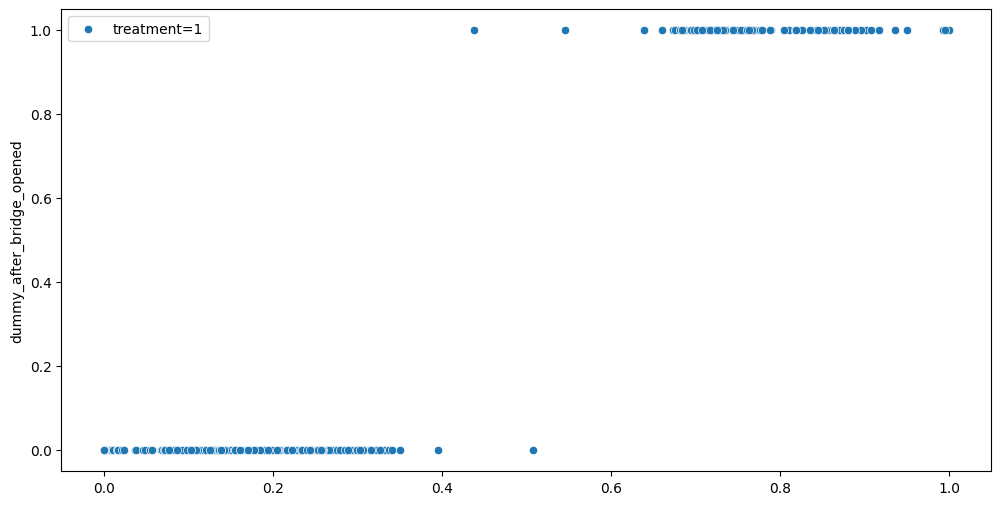

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=treatment_pred_1, y=treatment, label='treatment=1')
plt.show()

## ATE

変数

- T: 処置変数
- Y: 被説明変数
- X: 共変量


$$
E[Y_i | T_i = 1] =
    \frac{T_i}{P(T = 1 | X_i)}Y_i
+ \left(\frac{1 - T_i}{P(T = 1 | X_i)}\right)\hat{Y^1_i} \\
$$


- 第1項: 処置群の観測アウトカム
- 第2項: 対照群が処置を受けた場合の予測アウトカム

$$
E[Y_i | T_i = 0] =
    \frac{1 - T_i}{P(T = 0 | X_i)}Y_i
+ \left(\frac{T_i}{P(T = 0 | X_i)}\right)\hat{Y^0_i}
$$

- 第1項: 対照群の観測アウトカム
- 第2項: 処置群が処置を受けなかった場合の予測アウトカム

$$
ATE = E[Y_i | T_i = 1] - E[Y_i | T_i = 0] \\
$$

In [8]:
# 処置群のITEを計算
ITE_1_i = target / treatment_pred_1 * treatment + (1 - treatment / treatment_pred_1) * target_1

# 対照群のITEを計算
ITE_0_i = target / treatment_pred_0 * (1 - treatment) + (1 - (1 - treatment) / treatment_pred_0) * target_0

# 推定ATEを計算
ATE = 1 / len(target) * (ITE_1_i - ITE_0_i).sum()
print(f"推定したATE: {ATE:.2f}")

推定したATE: 0.03


## ブートストラップ法

In [14]:
# ブートストラップサンプルの数
n_bootstraps = 1000
bootstrapped_ates = []

# ブートストラップサンプルを生成してATEを計算
for _ in range(n_bootstraps):
    # ブートストラップサンプルを生成
    bootstrap_sample = df_filtered.sample(n=len(df_filtered), replace=True)

    # 負の二項分布でモデルを推定
    group_bootstrap = bootstrap_sample[['island_id', 'year']]
    target_bootstrap = bootstrap_sample['population']
    X_bootstrap = dmatrix('dummy_after_bridge_opened + log_income + area_km2 + distance_m', data=bootstrap_sample, return_type='dataframe')
    negbino_model = gpb.GPModel(group_data=group_bootstrap, likelihood='negative_binomial') # 負の二項分布
    negbino_model.fit(y=target_bootstrap, X=X_bootstrap)
    # treatment = 0 の予測
    treatment_0 = X_bootstrap.copy()
    treatment_0['dummy_after_bridge_opened'] = 0
    target_0_bootstrap = negbino_model.predict(X_pred=treatment_0, group_data_pred=group_bootstrap)['mu']
    # treatment = 1 の予測
    treatment_1 = X_bootstrap.copy()
    treatment_1['dummy_after_bridge_opened'] = 1
    target_1_bootstrap = negbino_model.predict(X_pred=treatment_1, group_data_pred=group_bootstrap)['mu']

    # 傾向スコアの計算
    # ロジスティック回帰
    treatment_bootstrap = bootstrap_sample['dummy_after_bridge_opened']
    covariates_bootstrap = dmatrix('log_income + area_km2 + distance_m', data=bootstrap_sample, return_type='dataframe')

    logistic_model = gpb.GPModel(group_data=group_bootstrap, likelihood='bernoulli_logit') # ベルヌーイ分布
    logistic_model.fit(y=treatment_bootstrap, X=covariates_bootstrap)

    treatment_pred_bootstrap_1 = logistic_model.predict(X_pred=covariates_bootstrap, group_data_pred=group_bootstrap)['mu']
    treatment_pred_bootstrap_0 = 1 - treatment_pred_bootstrap_1

    # ATEを計算
    # 処置群を計算
    ITE_1_i_bootstrap = target_bootstrap / treatment_pred_bootstrap_1 * treatment_bootstrap + (1 - treatment_bootstrap / treatment_pred_bootstrap_1) * target_1_bootstrap
    # 対照群を計算
    ITE_0_i_bootstrap = target_bootstrap / treatment_pred_bootstrap_0 * (1 - treatment_bootstrap) + (1 - (1 - treatment_bootstrap) / treatment_pred_bootstrap_0) * target_0_bootstrap

    # 推定ATEを計算
    bootstrapped_ate = 1 / len(target_bootstrap) * (ITE_1_i_bootstrap - ITE_0_i_bootstrap).sum()

    bootstrapped_ates.append(bootstrapped_ate)

# ATEの標準誤差を計算
standard_error = np.std(bootstrapped_ates)

# ATEの信頼区間を計算
lower_bound = np.percentile(bootstrapped_ates, 2.5)
upper_bound = np.percentile(bootstrapped_ates, 97.5)

print(f'ATE: {ATE:.2f}')
print(f'Standard Error: {standard_error:.2f}')
print(f'95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]')

ATE: 0.03
Standard Error: 160.16
95% Confidence Interval: [-396.27, 227.26]


## 結果

- ATE: 0.03
- Standard Error: 160.16
- 95% Confidence Interval: [-396.27, 227.26]

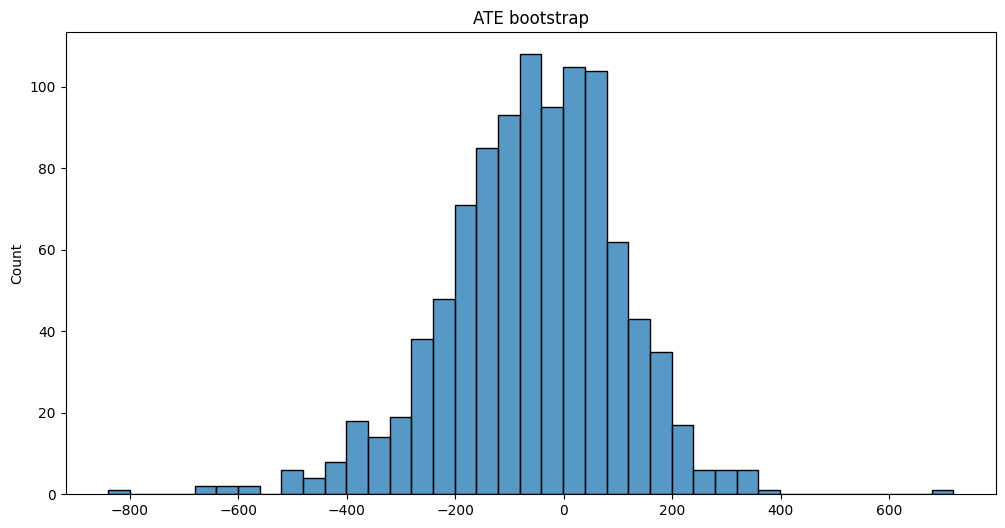

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(bootstrapped_ates)
plt.title('ATE bootstrap')
plt.show()

## 共変量のバランスチェック

In [17]:
# 1. 共変量のバランスチェック
def standardized_mean_difference(X, treatment):
    treated = X[treatment == 1]
    control = X[treatment == 0]
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    return mean_diff / pooled_std

smd = standardized_mean_difference(X, treatment)
print("Standardized Mean Differences (SMD):")
print(smd)
print('---')
print('|SMD| < 0.1: good balance')
print('0.1 < |SMD| < 0.2: acceptable balance')
print('0.2 < |SMD|: poor balance')
print('0.3 < |SMD|: very poor balance')

Standardized Mean Differences (SMD):
Intercept                         NaN
dummy_after_bridge_opened         inf
log_income                  -0.010724
dtype: float64
---
|SMD| < 0.1: good balance
0.1 < |SMD| < 0.2: acceptable balance
0.2 < |SMD|: poor balance
0.3 < |SMD|: very poor balance


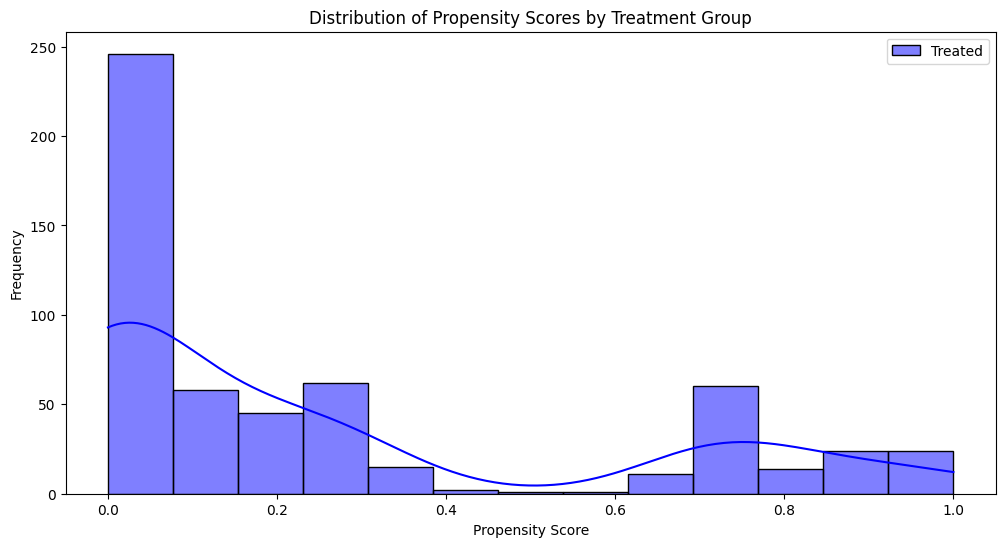

In [25]:
# 2. 傾向スコアの分布のプロット
plt.figure(figsize=(12, 6))
sns.histplot(treatment_pred_1, color='blue', label='Treated', kde=True)
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.show()

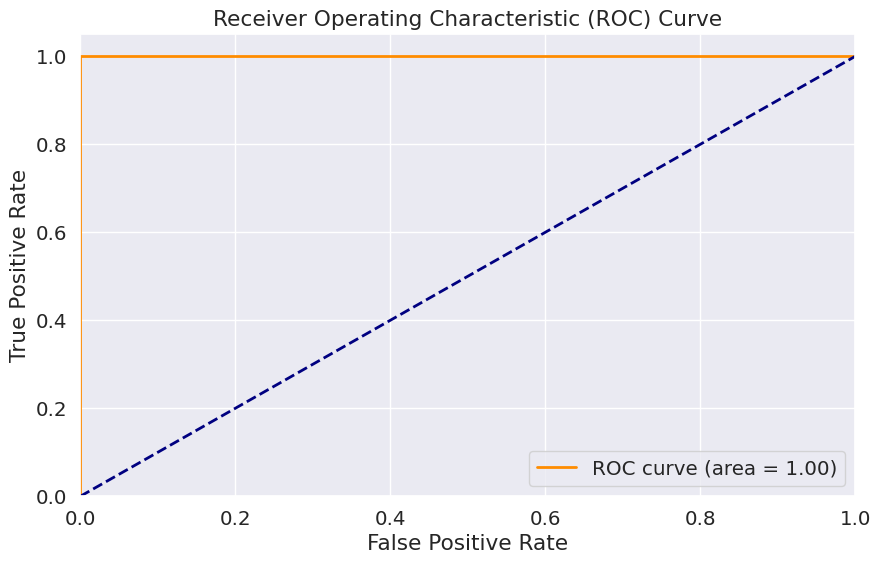

In [64]:
# 3. ロジスティック回帰モデルの診断
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(treatment, propensity_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()